In [10]:
import functools
from collections import namedtuple
from pathlib import Path

from copy import deepcopy

import numpy as np

from scipy import signal, interpolate

from astropy import units as u
from astropy.modeling import models, fitting
from astropy.visualization import quantity_support
quantity_support()

from matplotlib import pyplot as plt

from tqdm.notebook import tqdm

In [2]:
import torch
from torch import nn
from torch.utils.data import DataLoader, TensorDataset, random_split

device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
tensor_dtype = torch.float32
if device == 'cpu':
    tensor_dtype = torch.float64
print(f"Using {device} device with dtype {tensor_dtype}")

Using cpu device with dtype torch.float64


In [3]:
alltensorpaths = list(Path('resampled_tensors').glob('*_2k.pt'))
len(alltensorpaths)

7508

In [4]:
headers = []
wls = []
fluxes = []

for pth in tqdm(alltensorpaths):
    data = torch.load(pth, weights_only=True)
    headers.append(data['header'])
    wls.append(data['wl'])
    fluxes.append(data['flux'])

fluxes = torch.stack(fluxes)

  0%|          | 0/7508 [00:00<?, ?it/s]

In [5]:
assert torch.all(torch.stack(wls)==wls[0])
wl = wls[0]
del wls

In [6]:
teff = torch.tensor([h['PHXTEFF'] for h in headers])
logg = torch.tensor([h['PHXLOGG'] for h in headers])
feh = torch.tensor([h['PHXM_H'] for h in headers])

infeatures = torch.stack([teff,logg,feh], dim=1)
infeature_names = 'Teff,logg,FeH'.split(',')

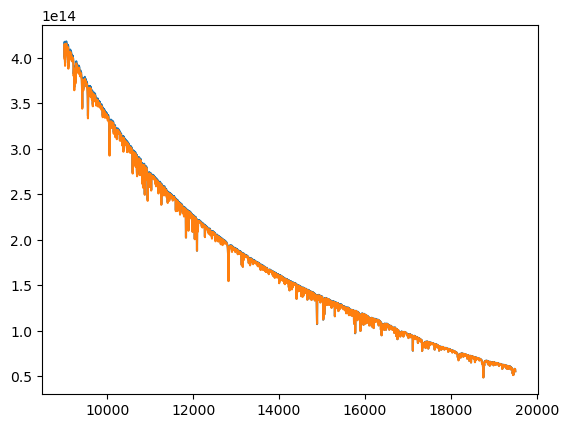

In [90]:
interper = interpolate.LinearNDInterpolator(infeatures.numpy().astype(float), fluxes)

plt.plot(wl, interper(5800, 5, 0))
plt.plot(wl, interper(5790, 4.9, 0))

In [91]:
%timeit interper(5790, 4.9, 0)

341 μs ± 5.52 μs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


Try a train/validation split

/tmp/ipykernel_24041/676847941.py:25: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  mses.append(torch.mean((vspec-ispec)**2 * vspec**-2))


np.float64(3.991553575706178e-05)

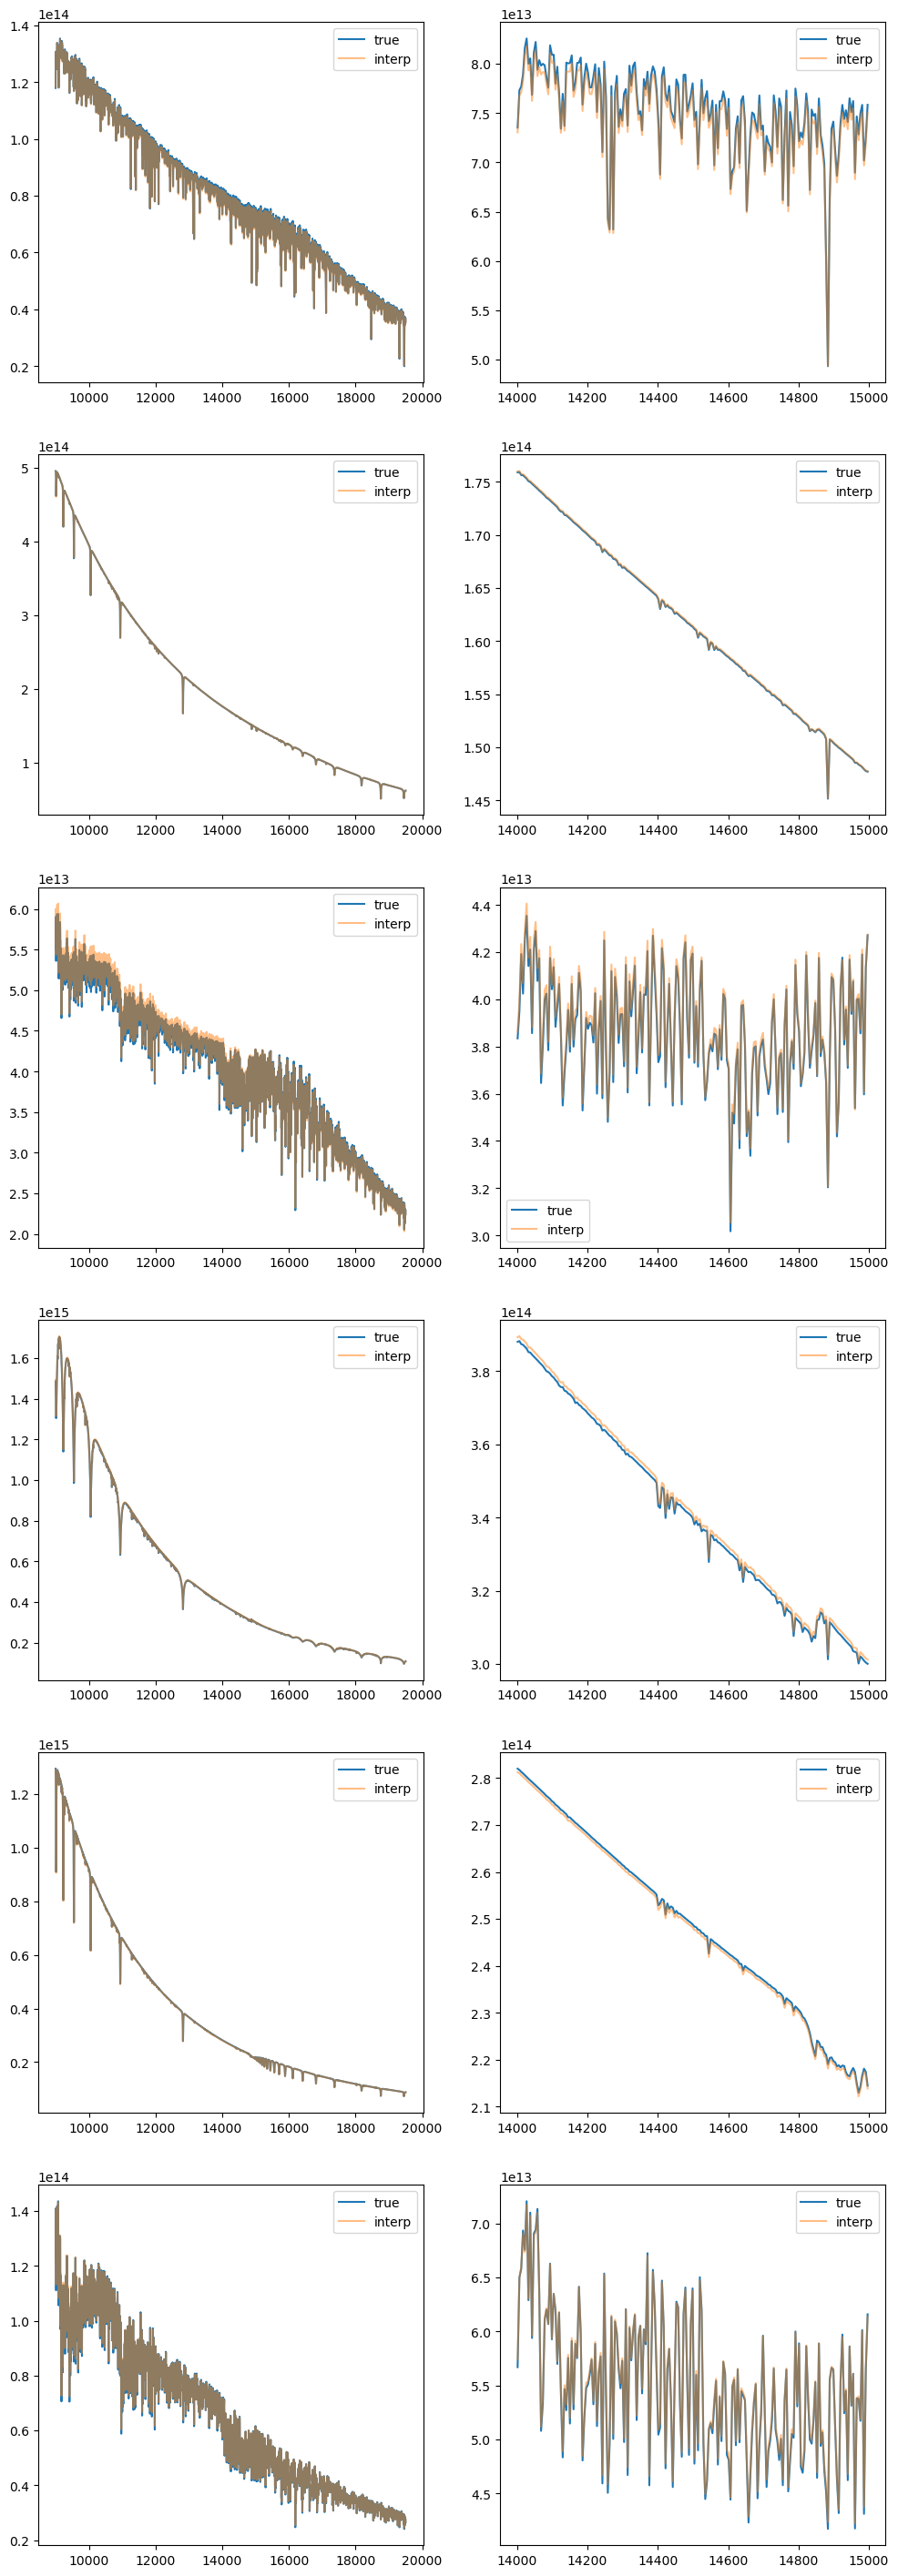

In [64]:
np.random.seed(43)
valid_idxs = np.random.permutation(len(fluxes))[:6]
train_msk = ~np.isin( np.arange(len(fluxes)), valid_idxs)

interper = interpolate.LinearNDInterpolator(infeatures[train_msk], fluxes[train_msk])

fig, axs = plt.subplots(len(valid_idxs), 2, figsize=(12, 6*len(valid_idxs)))

mses = []
for i, row in zip(valid_idxs, axs):
    ax1, ax2 = row
    
    ispec = interper(*infeatures[i])
    vspec = fluxes[i]

    ax1.plot(wl, vspec, label='true')
    ax1.plot(wl, ispec, label='interp', alpha=.5)
    ax1.legend(loc=0)

    msk = (14000<wl)&(wl<15000)
    ax2.plot(wl[msk], vspec[msk], label='true')
    ax2.plot(wl[msk], ispec[msk], label='interp', alpha=.5)
    ax2.legend(loc=0)

    mses.append(torch.mean((vspec-ispec)**2 * vspec**-2))

np.mean(mses)

  0%|          | 0/7508 [00:00<?, ?it/s]

(np.float64(0.0002060295211686713), np.float64(-4.5960086430010865))

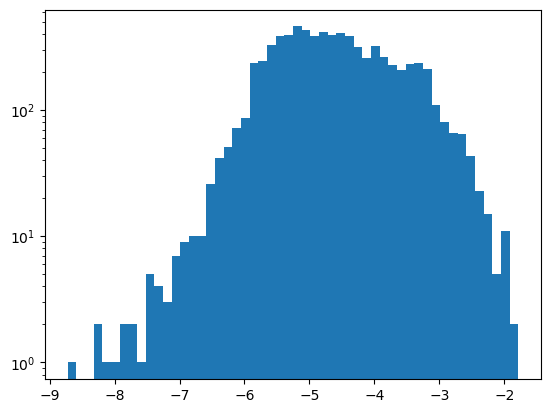

In [112]:
mses = []

for i in tqdm(np.random.permutation(len(fluxes))):
    train_msk = np.ones(len(fluxes), dtype=bool)
    train_msk[i] = False
    
    interper = interpolate.LinearNDInterpolator(infeatures[train_msk], fluxes[train_msk])
    
    ispec = interper(*infeatures[i])
    vspec = fluxes[i]

    mses.append(torch.mean((1 - ispec/vspec)**2).item())
    
plt.hist(np.log10(mses), bins='auto', log=True);
np.nanmean(mses), np.nanmean(np.log10(mses))

Try the RBF interpolator since it's basically the same in scipy

In [92]:
interper = interpolate.RBFInterpolator(infeatures, fluxes)

%timeit interper([[5790, 4.9, 0]])

3.44 ms ± 76.8 μs per loop (mean ± std. dev. of 7 runs, 100 loops each)


/tmp/ipykernel_24041/1018476986.py:25: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  mses.append(torch.mean((vspec-ispec)**2 * vspec**-2))


np.float64(0.0001524158919976712)

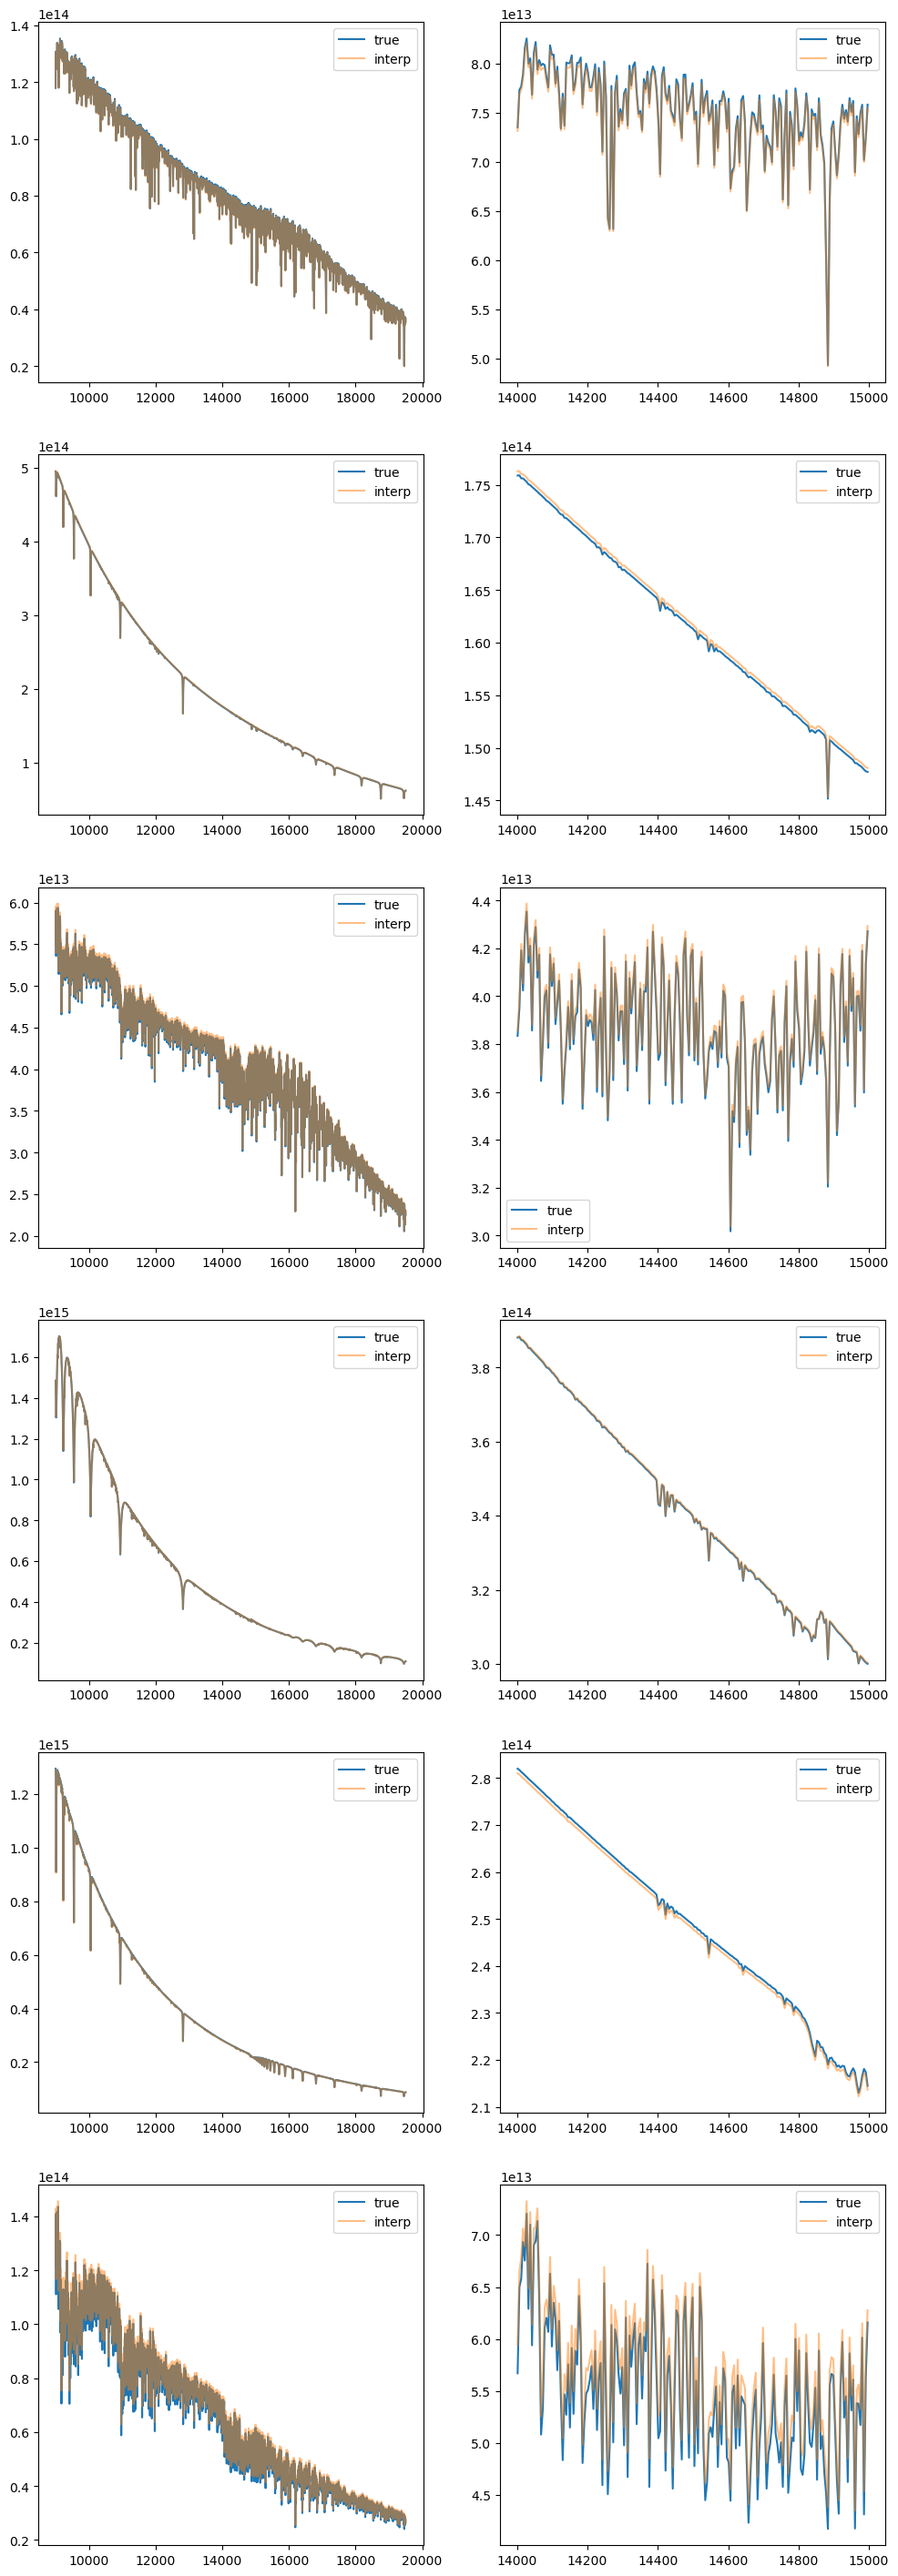

In [105]:
np.random.seed(43)
valid_idxs = np.random.permutation(len(fluxes))[:6]
train_msk = ~np.isin( np.arange(len(fluxes)), valid_idxs)

interper = interpolate.RBFInterpolator(infeatures[train_msk], fluxes[train_msk], kernel='thin_plate_spline', epsilon=1)

fig, axs = plt.subplots(len(valid_idxs), 2, figsize=(12, 6*len(valid_idxs)))

mses = []
for i, row in zip(valid_idxs, axs):
    ax1, ax2 = row
    
    ispec = interper(infeatures[i].numpy()[None,...])[0]
    vspec = fluxes[i]

    ax1.plot(wl, vspec, label='true')
    ax1.plot(wl, ispec, label='interp', alpha=.5)
    ax1.legend(loc=0)

    msk = (14000<wl)&(wl<15000)
    ax2.plot(wl[msk], vspec[msk], label='true')
    ax2.plot(wl[msk], ispec[msk], label='interp', alpha=.5)
    ax2.legend(loc=0)

    mses.append(torch.mean((vspec-ispec)**2 * vspec**-2))

np.mean(mses)

Neither seems to do as good as the autoencoder approach. And the RBF is def slower